# Supervised Learning of Drug Response using CORES from Copy Number Log Ratio

### Import Python source code

In [52]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 26 12:21:38 2018

@author: bbece
"""

from __future__ import division, print_function, unicode_literals
import numpy as np
import os
from IPython.display import display, HTML

from pprint import pprint
np.random.seed(42)

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
            
import pandas as pd
import scipy

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler

from sklearn import decomposition

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from sklearn.tree import export_graphviz

import math



### Define method to split training and testing set

In [53]:
# TODO: Manipulate test_ratio
def split_train_test(training_set, test_ratio = 0.33):
    row_count = training_set.shape[0]
    shuffled_indices = np.random.permutation(row_count)
    test_set_size = int(test_ratio * row_count)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return training_set.iloc[train_indices], training_set.iloc[test_indices]

### Load training set matrix

In [54]:
labeled_matrix_training_set = pd.read_csv("../mlOutput/coreTrainingSet_8_3_2018_1.csv")
#labeled_matrix_training_set.columns.values[0] = "sampleId"
labeled_matrix_training_set = labeled_matrix_training_set.drop([labeled_matrix_training_set.columns[0]], axis = 1)
labels = list(range(0,5))


In [55]:
display(labeled_matrix_training_set.head(25))

,Gemcitabine,Paclitaxel,SN-38,5-FU,Oxaliplatin,1,2,3,4,5,...,20.1,21.1,22.1,23,24,25,26,27,28,29
0,0.576312,0.715357,0.542345,0.770327,0.875863,0,0.000000,0.000000,0,0,...,0.392288,0.078721,0.000000,0.000000,0.000000,0.167822,0.000000,0.000000,0.000000,0.000000
1,0.531357,0.481223,0.552329,0.778592,0.802963,0,0.000000,0.000000,1,0,...,0.059951,0.038275,0.377962,0.446879,0.710431,0.000000,0.000000,0.000000,0.003203,0.000000
2,0.610292,0.748410,0.544124,0.673957,0.790218,0,0.663784,0.000000,0,0,...,0.000000,0.000000,0.932381,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.677571,0.647227,0.562632,0.826889,0.835748,0,0.000000,0.000000,0,0,...,0.000000,0.028650,0.000000,0.000000,0.000000,0.000000,0.000000,0.107368,0.000000,0.000000
4,0.694529,0.653745,0.651769,0.850960,0.813800,0,0.000000,0.000000,0,0,...,0.233416,0.035632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.625919,0.546421,0.570326,0.723314,0.943585,0,0.000000,0.000000,1,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.619415,0.566868,0.548342,0.755120,0.841761,0,0.000000,0.000000,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.557171,0.577914,0.611604,0.895087,0.914860,0,0.000000,0.000000,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.821077,0.698895,0.790806,NaN,NaN,0,0.000000,0.997074,0,0,...,0.000000,0.000000,0.000000,0.471892,0.000000,0.000000,0.000000,0.003510,0.000000,0.000000
9,NaN,NaN,NaN,NaN,NaN,0,0.000000,0.000000,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [56]:
X = labeled_matrix_training_set.copy().drop(labeled_matrix_training_set.columns[labels], axis = 1)
y = labeled_matrix_training_set.copy()[labeled_matrix_training_set.columns[labels]]

In [57]:
display(X.head())

,1,2,3,4,5,6,7,8,9,10,...,20.1,21.1,22.1,23,24,25,26,27,28,29
0,0,0.000000,0.0,0,0,0.000000,0.0,0.0,0.000000,0.0,...,0.392288,0.078721,0.000000,0.000000,0.000000,0.167822,0.0,0.000000,0.000000,0.0
1,0,0.000000,0.0,1,0,0.000000,0.0,0.0,0.000000,0.0,...,0.059951,0.038275,0.377962,0.446879,0.710431,0.000000,0.0,0.000000,0.003203,0.0
2,0,0.663784,0.0,0,0,0.915058,0.0,0.0,0.137935,0.0,...,0.000000,0.000000,0.932381,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
3,0,0.000000,0.0,0,0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.028650,0.000000,0.000000,0.000000,0.000000,0.0,0.107368,0.000000,0.0
4,0,0.000000,0.0,0,0,0.000000,0.0,0.0,0.000000,0.0,...,0.233416,0.035632,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0


In [58]:
display(y.head(15))

,Gemcitabine,Paclitaxel,SN-38,5-FU,Oxaliplatin
0,0.576312,0.715357,0.542345,0.770327,0.875863
1,0.531357,0.481223,0.552329,0.778592,0.802963
2,0.610292,0.748410,0.544124,0.673957,0.790218
3,0.677571,0.647227,0.562632,0.826889,0.835748
4,0.694529,0.653745,0.651769,0.850960,0.813800
5,0.625919,0.546421,0.570326,0.723314,0.943585
6,0.619415,0.566868,0.548342,0.755120,0.841761
7,0.557171,0.577914,0.611604,0.895087,0.914860
8,0.821077,0.698895,0.790806,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN


In [59]:
from sklearn.model_selection import train_test_split

all_X_TRAIN, all_X_TEST, all_Y_TRAIN, all_Y_TEST = train_test_split(X, y, test_size=0.20, random_state=42)
# TODO: train_test must be split on amount of NAs as well!

In [60]:
display(all_X_TRAIN.head())
display(all_Y_TRAIN.head())

,1,2,3,4,5,6,7,8,9,10,...,20.1,21.1,22.1,23,24,25,26,27,28,29
77,0,0.000000,0.000000,0,0,0.000000,0.000000,0.95,0.000000,0.000000,...,0.000000,0.897651,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.847304,0.000000
42,1,0.663784,0.997398,0,0,0.000000,0.871818,0.00,0.137935,0.431086,...,0.083147,0.000000,0.377962,0.619782,0.00000,0.728292,0.0,0.0,0.000000,0.000000
49,0,0.000000,0.000000,0,1,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.000000
11,0,0.663784,0.000000,0,1,0.915058,0.000000,0.00,0.137935,0.000000,...,0.163698,0.000000,0.000000,0.000000,0.42819,0.000000,0.0,0.0,0.189002,0.000000
30,0,0.663784,0.000000,0,0,0.000000,0.000000,0.00,0.137935,0.000000,...,0.036827,0.000000,0.000000,0.288723,0.00000,0.000000,0.0,0.0,0.004460,0.877955


,Gemcitabine,Paclitaxel,SN-38,5-FU,Oxaliplatin
77,NaN,NaN,NaN,NaN,NaN
42,0.645679,0.630910,0.682710,0.942370,0.839335
49,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN
30,0.637520,0.652945,0.679371,0.822522,0.927028


In [61]:
display(all_X_TEST.head())
display(all_Y_TEST.head())

,1,2,3,4,5,6,7,8,9,10,...,20.1,21.1,22.1,23,24,25,26,27,28,29
78,0,0.000000,0.000000,0,0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.008761,0.000000,0.000000
0,0,0.000000,0.000000,0,0,0.000000,0.0,0.0,0.000000,0.0,...,0.392288,0.078721,0.0,0.0,0.00000,0.167822,0.0,0.000000,0.000000,0.000000
68,1,0.663784,0.399480,0,0,0.915058,0.0,0.0,0.137935,0.0,...,0.000000,0.000000,0.0,0.0,0.42819,0.000000,0.0,0.000000,0.000000,0.000000
22,0,0.000000,0.682574,1,1,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.007712,0.434028
12,1,0.663784,0.000000,0,1,0.915058,0.0,0.0,0.137935,0.0,...,0.058456,0.000000,0.0,0.0,0.42819,0.000000,0.0,0.000000,0.000000,0.434028


,Gemcitabine,Paclitaxel,SN-38,5-FU,Oxaliplatin
78,0.777284,0.745540,0.701093,0.924357,0.866260
0,0.576312,0.715357,0.542345,0.770327,0.875863
68,NaN,NaN,NaN,NaN,NaN
22,0.915466,0.756732,0.877780,0.963176,1.000000
12,NaN,NaN,NaN,NaN,NaN


## Visualize ML Results

In [62]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

In [63]:
def retrieve_pipelines(model_name, ml_model):
    Ypipeline = Pipeline([
     ('imputer', Imputer(axis=0,strategy="median")),
     #('standardizer', StandardScaler()),
    ('normalizer', MinMaxScaler())
    ])

    XYpipeline = Pipeline([
            ('imputer', Imputer(axis=0,strategy="median")),
            #('standardizer', StandardScaler()),
            #('normalizer', MinMaxScaler()),
            #("pca", decomposition.PCA(n_components=10)),
            (model_name,  ml_model)
    ])
    
    return (Ypipeline, XYpipeline)

def imputer_inverse_transform(pre_data, post_data):
    na_indices = np.where(np.isnan(pre_data))[0]
    post_data[na_indices] = float('NaN')
    return post_data
    
def remove_NAs(X, y, label):
    label_y = y[[y.columns[label]]]
    na_indices = label_y[label_y.columns[0]].index[label_y[label_y.columns[0]].apply(np.isnan)]
    y_nonNA = label_y.copy().drop(na_indices)
    X_nonNA = X.copy().drop(na_indices)
    return X_nonNA, y_nonNA
    
def train_and_test(Ypipeline, XYpipeline, X_TRAIN, X_TEST, this_y_train, this_y_test):
    this_y_train_tr = Ypipeline.fit_transform(this_y_train)
    XYpipeline.fit(X_TRAIN,this_y_train_tr)

    y_test_tr = Ypipeline.transform(this_y_test)
    y_prediction = XYpipeline.predict(X_TEST)

    y_prediction = Ypipeline.named_steps['normalizer'].inverse_transform(y_prediction)
    y_prediction = imputer_inverse_transform(this_y_test, y_prediction)

    y_test_np = this_y_test
    y_test_np = y_test_np[~np.isnan(y_test_np)]
    y_prediction = y_prediction[~np.isnan(y_prediction)]
    return (y_test_np, y_prediction, this_y_train_tr)


def simple_score(y_test_np, y_prediction):
    rmse = np.sqrt(mean_squared_error(y_test_np, y_prediction))
    r = scipy.stats.pearsonr(y_test_np, y_prediction)
    t = scipy.stats.spearmanr(y_test_np, y_prediction)
    return (rmse, r, t)
    
def visualize(y_test_np, y_prediction):
    plt.plot(y_test_np, y_prediction, 'bo')
    abline(1,0)
    plt.ylabel("Prediction")
    plt.xlabel("Label")
    plt.show()
    
def display_set(X_TRAIN, X_TEST, Y_TRAIN, Y_TEST):
    TRAIN = pd.concat([Y_TRAIN, X_TRAIN], axis=1)
    TEST = pd.concat([Y_TEST, X_TEST], axis=1)
    pprint("TRAIN")
    display(TRAIN)
    pprint("TEST")
    display(TEST)

def cv_score(XYpipeline, X_TRAIN, this_y_train_tr):
    scores = cross_val_score(XYpipeline, X_TRAIN, this_y_train_tr,
                             scoring = "neg_mean_squared_error", cv=10)
    scores = Ypipeline.named_steps['normalizer'].inverse_transform(scores)
    return scores


### Visualize ML results using Linear Regression

'TRAIN'


,Gemcitabine,1,2,3,4,5,6,7,8,9,...,20.1,21.1,22.1,23,24,25,26,27,28,29
17,0.620575,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.053096,0.078721,0.000000,0.403419,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
38,0.659406,1,0.671536,0.000000,0,0,0.000000,0.000000,0.000000,0.412359,...,0.226967,0.067449,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.283470,0.000000
39,0.588977,1,0.000000,0.995087,1,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.064604,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.677571,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.028650,0.000000,0.000000,0.000000,0.000000,0.000000,0.107368,0.000000,0.000000
22,0.915466,0,0.000000,0.682574,1,1,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007712,0.434028
72,0.592928,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.067860,0.039466,0.000000,0.000000,0.000000,0.000000,0.000000,0.009820,0.000000,0.446860
8,0.821077,0,0.000000,0.997074,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.471892,0.000000,0.000000,0.000000,0.003510,0.000000,0.000000
6,0.619415,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
36,0.703385,1,0.000000,1.000000,1,0,1.000000,0.000000,0.000000,0.987730,...,0.667935,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009820,0.000000,0.000000
4,0.694529,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.233416,0.035632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


'TEST'


,Gemcitabine,1,2,3,4,5,6,7,8,9,...,20.1,21.1,22.1,23,24,25,26,27,28,29
61,0.790540,0,0.939401,0.399480,0,0,0.915058,0.000000,0.744641,0.035184,...,0.870398,0.039806,0.0,0.530704,0.428190,0.000000,0.000000,0.000000,0.004444,0.000000
75,0.547590,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.870398,0.493904,0.0,0.471838,0.000000,0.193245,0.552905,0.000000,0.000000,0.000000
0,0.576312,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.392288,0.078721,0.0,0.000000,0.000000,0.167822,0.000000,0.000000,0.000000,0.000000
76,0.594579,0,0.000000,0.000000,0,0,0.000000,0.000000,0.940662,0.000000,...,0.000000,0.897651,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.625919,0,0.000000,0.000000,1,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
59,0.574839,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
21,0.597597,0,0.929884,0.961098,1,0,0.915058,0.000000,0.000000,0.040297,...,0.000000,0.356861,0.0,0.000000,0.000000,0.490114,0.000000,0.000000,0.004665,0.000000
16,0.646874,0,0.000000,0.000000,0,0,0.000000,0.000000,0.950000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.685548,0.000000,0.000000,0.000000,0.000000
30,0.637520,0,0.663784,0.000000,0,0,0.000000,0.000000,0.000000,0.137935,...,0.036827,0.000000,0.0,0.288723,0.000000,0.000000,0.000000,0.000000,0.004460,0.877955
79,0.726312,0,0.000000,0.000000,0,0,0.000000,0.871818,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.694419,0.810804,0.000000,0.000000,0.000000,0.000000


RMSE: 0.104531925045
Pearson: (0.0097073460528236608, 0.9748916215843072)
Spearman: SpearmanrResult(correlation=0.16483516483516483, pvalue=0.59047898865200499)


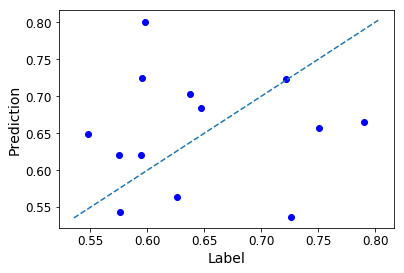

'TRAIN'


,Paclitaxel,1,2,3,4,5,6,7,8,9,...,20.1,21.1,22.1,23,24,25,26,27,28,29
37,0.706000,1,0.000000,1.000000,0,0,1.000000,0.000000,0.000000,0.987730,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.748410,0,0.663784,0.000000,0,0,0.915058,0.000000,0.000000,0.137935,...,0.000000,0.000000,0.932381,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
23,0.662895,0,0.000000,0.982915,1,0,0.000000,0.000000,0.940662,0.000000,...,0.000000,0.347998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
78,0.745540,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008761,0.000000,0.000000
14,0.628936,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.552905,0.000000,0.000000,0.000000
73,0.641439,0,0.663784,0.000000,1,1,0.000000,0.000000,0.000000,0.137935,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.647080,0.000000,0.000000,0.000000,0.000000
15,0.564116,0,0.943002,0.000000,0,0,0.000000,0.000000,0.000000,0.033220,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
56,0.588074,0,0.000000,0.000000,0,0,0.000000,0.871818,0.000000,0.000000,...,0.870398,0.039806,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
31,0.667870,1,0.916311,0.000000,1,0,0.000000,0.872366,0.000000,0.047396,...,0.000000,0.078721,1.000000,0.000000,0.000000,0.000000,0.998330,0.986175,0.000000,0.625731
6,0.566868,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


'TEST'


,Paclitaxel,1,2,3,4,5,6,7,8,9,...,20.1,21.1,22.1,23,24,25,26,27,28,29
44,0.519171,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0
24,0.560880,0,0.663784,0.509478,0,0,0.000000,0.000000,0.000000,0.137935,...,0.060131,0.000000,0.000000,0.447953,0.00000,0.345972,0.0,0.000000,0.000000,0.0
84,0.558231,0,0.000000,0.000000,0,0,0.000000,0.000000,0.995228,0.869212,...,0.000000,0.446125,0.000000,0.000000,0.00000,0.000000,0.0,0.000595,0.000000,0.0
63,0.538041,0,0.981870,1.000000,0,0,0.000000,0.000000,0.000000,0.011002,...,0.000000,0.000000,0.000000,0.612868,0.00000,0.000000,0.0,0.068967,0.000000,0.0
26,0.596468,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.068618,0.032451,0.377962,0.000000,0.00000,0.000000,0.0,0.000000,0.910626,0.0
61,0.826007,0,0.939401,0.399480,0,0,0.915058,0.000000,0.744641,0.035184,...,0.870398,0.039806,0.000000,0.530704,0.42819,0.000000,0.0,0.000000,0.004444,0.0
36,0.716384,1,0.000000,1.000000,1,0,1.000000,0.000000,0.000000,0.987730,...,0.667935,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.009820,0.000000,0.0
71,0.722832,0,0.000000,0.000000,0,0,0.915058,0.834942,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0
42,0.630910,1,0.663784,0.997398,0,0,0.000000,0.871818,0.000000,0.137935,...,0.083147,0.000000,0.377962,0.619782,0.00000,0.728292,0.0,0.000000,0.000000,0.0
55,0.593731,0,0.000000,0.000000,0,0,0.000000,0.871818,0.000000,0.000000,...,0.000000,0.018987,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0


RMSE: 0.0837231657305
Pearson: (0.272200687521435, 0.36827826547467923)
Spearman: SpearmanrResult(correlation=0.24725274725274726, pvalue=0.41540511972553817)


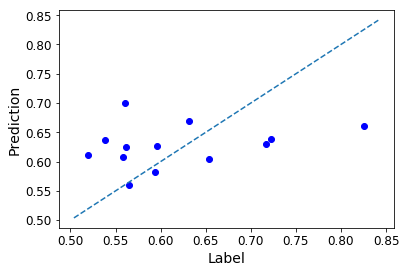

'TRAIN'


,SN-38,1,2,3,4,5,6,7,8,9,...,20.1,21.1,22.1,23,24,25,26,27,28,29
40,0.557068,1,0.000000,0.000000,1,0,0.000000,0.458361,0.000000,0.000000,...,0.000000,0.961309,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
19,0.602164,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.197832,0.545890,0.000000,0.000000,0.000000,0.464498,0.000000,1.000000,0.000000,0.446860
15,0.560100,0,0.943002,0.000000,0,0,0.000000,0.000000,0.000000,0.033220,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.570326,0,0.000000,0.000000,1,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
33,0.590799,1,0.000000,0.913472,0,0,0.000000,0.871818,0.943491,0.000000,...,0.064264,0.000000,0.994948,0.471079,0.000000,0.000000,0.998116,0.579642,0.000000,0.000000
10,0.711736,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.529085,0.000000,0.000000
1,0.552329,0,0.000000,0.000000,1,0,0.000000,0.000000,0.000000,0.000000,...,0.059951,0.038275,0.377962,0.446879,0.710431,0.000000,0.000000,0.000000,0.003203,0.000000
23,0.491755,0,0.000000,0.982915,1,0,0.000000,0.000000,0.940662,0.000000,...,0.000000,0.347998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
32,0.606223,1,0.898766,0.000000,1,0,0.000000,0.905644,0.943491,0.056235,...,0.063434,0.078721,1.000000,0.466730,0.428190,0.000000,0.998116,0.986175,0.000000,0.000000
80,0.610227,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.032451,0.000000,0.000000,0.000000,0.000000,0.000000,0.185975,0.769782,0.000000


'TEST'


,SN-38,1,2,3,4,5,6,7,8,9,...,20.1,21.1,22.1,23,24,25,26,27,28,29
24,0.560497,0,0.663784,0.509478,0,0,0.000000,0.000000,0.000000,0.137935,...,0.060131,0.000000,0.0,0.447953,0.00000,0.345972,0.000000,0.000000,0.000000,0.000000
56,0.647026,0,0.000000,0.000000,0,0,0.000000,0.871818,0.000000,0.000000,...,0.870398,0.039806,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.611604,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
35,0.577066,1,0.000000,1.000000,1,0,1.000000,0.832143,0.749908,0.987730,...,0.000000,0.078721,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
46,0.489531,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.42819,0.000000,0.000000,0.000000,0.000000,0.000000
21,0.621525,0,0.929884,0.961098,1,0,0.915058,0.000000,0.000000,0.040297,...,0.000000,0.356861,0.0,0.000000,0.00000,0.490114,0.000000,0.000000,0.004665,0.000000
55,0.578875,0,0.000000,0.000000,0,0,0.000000,0.871818,0.000000,0.000000,...,0.000000,0.018987,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
22,0.877780,0,0.000000,0.682574,1,1,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.007712,0.434028
71,0.635591,0,0.000000,0.000000,0,0,0.915058,0.834942,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25,0.579003,0,0.982908,0.000000,0,0,0.000000,0.834942,0.940662,0.010383,...,0.000000,0.039466,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000


RMSE: 0.113785006007
Pearson: (-0.22597199808898452, 0.45787929236934394)
Spearman: SpearmanrResult(correlation=-0.3681318681318681, pvalue=0.21585718064938147)


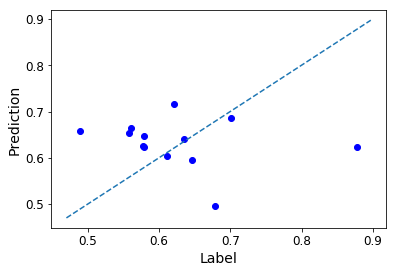

'TRAIN'


,5-FU,1,2,3,4,5,6,7,8,9,...,20.1,21.1,22.1,23,24,25,26,27,28,29
61,0.875244,0,0.939401,0.399480,0,0,0.915058,0.000000,0.744641,0.035184,...,0.870398,0.039806,0.000000,0.530704,0.428190,0.000000,0.000000,0.000000,0.004444,0.000000
30,0.822522,0,0.663784,0.000000,0,0,0.000000,0.000000,0.000000,0.137935,...,0.036827,0.000000,0.000000,0.288723,0.000000,0.000000,0.000000,0.000000,0.004460,0.877955
21,0.754820,0,0.929884,0.961098,1,0,0.915058,0.000000,0.000000,0.040297,...,0.000000,0.356861,0.000000,0.000000,0.000000,0.490114,0.000000,0.000000,0.004665,0.000000
71,0.778938,0,0.000000,0.000000,0,0,0.915058,0.834942,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
31,0.839585,1,0.916311,0.000000,1,0,0.000000,0.872366,0.000000,0.047396,...,0.000000,0.078721,1.000000,0.000000,0.000000,0.000000,0.998330,0.986175,0.000000,0.625731
35,0.655291,1,0.000000,1.000000,1,0,1.000000,0.832143,0.749908,0.987730,...,0.000000,0.078721,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
36,0.686940,1,0.000000,1.000000,1,0,1.000000,0.000000,0.000000,0.987730,...,0.667935,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009820,0.000000,0.000000
41,0.845183,0,0.000000,0.440834,0,0,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.778783,0.000000,0.095651,0.772234,0.000000
15,0.724743,0,0.943002,0.000000,0,0,0.000000,0.000000,0.000000,0.033220,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.826889,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.028650,0.000000,0.000000,0.000000,0.000000,0.000000,0.107368,0.000000,0.000000


'TEST'


,5-FU,1,2,3,4,5,6,7,8,9,...,20.1,21.1,22.1,23,24,25,26,27,28,29
23,0.735328,0,0.000000,0.982915,1,0,0.0,0.000000,0.940662,0.000000,...,0.000000,0.347998,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
84,0.847659,0,0.000000,0.000000,0,0,0.0,0.000000,0.995228,0.869212,...,0.000000,0.446125,0.0,0.000000,0.0,0.0,0.000000,0.000595,0.000000,0.000000
25,0.776366,0,0.982908,0.000000,0,0,0.0,0.834942,0.940662,0.010383,...,0.000000,0.039466,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
14,0.831634,0,0.000000,0.000000,0,0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.552905,0.000000,0.000000,0.000000
6,0.755120,0,0.000000,0.000000,0,0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
78,0.924357,0,0.000000,0.000000,0,0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.008761,0.000000,0.000000
80,0.848018,0,0.000000,0.000000,0,0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.032451,0.0,0.000000,0.0,0.0,0.000000,0.185975,0.769782,0.000000
60,0.762266,0,0.000000,0.000000,0,0,0.0,0.000000,0.000000,0.000000,...,0.052805,0.038126,0.0,0.401489,0.0,0.0,0.000000,0.000000,0.000000,0.999993
62,0.794304,0,0.000000,0.977566,0,0,0.0,0.000000,0.000000,0.896149,...,0.163698,0.043257,0.0,0.366310,0.0,0.0,0.000000,0.001529,0.080909,0.446040
58,0.874941,0,0.000000,0.000000,1,0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.078721,0.0,0.000000,0.0,0.0,0.553212,0.009820,0.000000,0.434028


RMSE: 0.115431987716
Pearson: (-0.13620498733223602, 0.67296204055407305)
Spearman: SpearmanrResult(correlation=-0.14685314685314685, pvalue=0.64879570978466639)


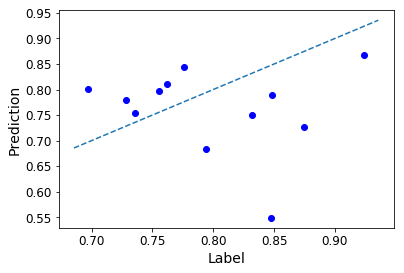

'TRAIN'


,Oxaliplatin,1,2,3,4,5,6,7,8,9,...,20.1,21.1,22.1,23,24,25,26,27,28,29
30,0.927028,0,0.663784,0.000000,0,0,0.000000,0.000000,0.000000,0.137935,...,0.036827,0.000000,0.000000,0.288723,0.000000,0.000000,0.000000,0.000000,0.004460,0.877955
63,0.703624,0,0.981870,1.000000,0,0,0.000000,0.000000,0.000000,0.011002,...,0.000000,0.000000,0.000000,0.612868,0.000000,0.000000,0.000000,0.068967,0.000000,0.000000
5,0.943585,0,0.000000,0.000000,1,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.835748,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.028650,0.000000,0.000000,0.000000,0.000000,0.000000,0.107368,0.000000,0.000000
7,0.914860,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
22,1.000000,0,0.000000,0.682574,1,1,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007712,0.434028
60,0.794773,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.052805,0.038126,0.000000,0.401489,0.000000,0.000000,0.000000,0.000000,0.000000,0.999993
27,0.814672,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.618669,0.000000,0.000000,0.000000,0.894808,0.000000,0.000000,0.000000,0.000000
62,0.914314,0,0.000000,0.977566,0,0,0.000000,0.000000,0.000000,0.896149,...,0.163698,0.043257,0.000000,0.366310,0.000000,0.000000,0.000000,0.001529,0.080909,0.446040
80,0.846689,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.032451,0.000000,0.000000,0.000000,0.000000,0.000000,0.185975,0.769782,0.000000


'TEST'


,Oxaliplatin,1,2,3,4,5,6,7,8,9,...,20.1,21.1,22.1,23,24,25,26,27,28,29
14,0.934615,0,0.0,0.000000,0,0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.552905,0.000000,0.000000,0.00000
26,0.886223,0,0.0,0.000000,0,0,0.000000,0.000000,0.0,0.0,...,0.068618,0.032451,0.377962,0.000000,0.000000,0.000000,0.000000,0.000000,0.910626,0.00000
17,0.800729,0,0.0,0.000000,0,0,0.000000,0.000000,0.0,0.0,...,0.053096,0.078721,0.000000,0.403419,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
18,0.850711,0,0.0,0.000000,0,0,0.000000,0.000000,0.0,0.0,...,0.000000,0.018987,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
71,0.919561,0,0.0,0.000000,0,0,0.915058,0.834942,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
19,0.854693,0,0.0,0.000000,0,0,0.000000,0.000000,0.0,0.0,...,0.197832,0.545890,0.000000,0.000000,0.000000,0.464498,0.000000,1.000000,0.000000,0.44686
44,0.783065,0,0.0,0.000000,0,0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
79,0.912904,0,0.0,0.000000,0,0,0.000000,0.871818,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.694419,0.810804,0.000000,0.000000,0.000000,0.00000
45,0.950017,0,0.0,0.000000,0,0,0.000000,0.000000,0.0,0.0,...,0.000000,0.078721,0.000000,0.000000,0.428190,0.000000,0.000000,0.000000,0.000000,0.00000
41,0.740179,0,0.0,0.440834,0,0,0.000000,1.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.778783,0.000000,0.095651,0.772234,0.00000


RMSE: 0.0777729641853
Pearson: (-0.027100925820056378, 0.93337158401529996)
Spearman: SpearmanrResult(correlation=-0.062937062937062943, pvalue=0.84593092122877889)


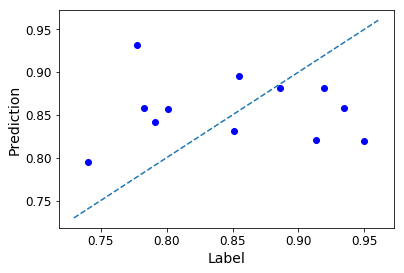

In [64]:
for label in labels:
    X_nonNA, y_nonNA = remove_NAs(X, y, label)
    X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X_nonNA, y_nonNA, test_size=0.20)
    
    display_set(X_TRAIN, X_TEST, Y_TRAIN, Y_TEST)
        
    Ypipeline, XYpipeline = retrieve_pipelines("ridge_model", Ridge(alpha = 0.8))
    
    y_test_np, y_prediction, this_y_train_tr = train_and_test(Ypipeline, XYpipeline, X_TRAIN, X_TEST, Y_TRAIN.values, Y_TEST.values)

    rmse, r, t = simple_score(y_test_np, y_prediction)
    
    print("RMSE: " + str(rmse))
    print("Pearson: " + str(r))
    print("Spearman: " + str(t))

    #scores = cv_score(XYpipeline, X_TRAIN, this_y_train_tr)
    
    #print("CV Scores: " + str(scores))
    #print("CV Mean: " + str(scores.mean()))
    #print("CV STD: " + str(scores.std()))
             
    visualize(y_test_np, y_prediction)


### Visualize ML results using Random Forest Regressor

'TRAIN'


,Gemcitabine,1,2,3,4,5,6,7,8,9,...,20.1,21.1,22.1,23,24,25,26,27,28,29
19,0.680200,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.197832,0.545890,0.000000,0.000000,0.000000,0.464498,0.000000,1.000000,0.000000,0.446860
80,0.690240,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.032451,0.000000,0.000000,0.000000,0.000000,0.000000,0.185975,0.769782,0.000000
28,0.784304,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.233980,0.039806,0.000000,0.000000,0.000000,0.000000,0.000000,0.303572,0.000000,0.000000
16,0.646874,0,0.000000,0.000000,0,0,0.000000,0.000000,0.950000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.685548,0.000000,0.000000,0.000000,0.000000
32,0.736595,1,0.898766,0.000000,1,0,0.000000,0.905644,0.943491,0.056235,...,0.063434,0.078721,1.000000,0.466730,0.428190,0.000000,0.998116,0.986175,0.000000,0.000000
59,0.574839,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
38,0.659406,1,0.671536,0.000000,0,0,0.000000,0.000000,0.000000,0.412359,...,0.226967,0.067449,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.283470,0.000000
84,0.591477,0,0.000000,0.000000,0,0,0.000000,0.000000,0.995228,0.869212,...,0.000000,0.446125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000595,0.000000,0.000000
45,0.699608,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.078721,0.000000,0.000000,0.428190,0.000000,0.000000,0.000000,0.000000,0.000000
53,0.736810,1,0.819769,0.000000,1,0,0.915058,0.000000,1.000000,0.091317,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.796484,0.000000


'TEST'


,Gemcitabine,1,2,3,4,5,6,7,8,9,...,20.1,21.1,22.1,23,24,25,26,27,28,29
1,0.531357,0,0.000000,0.000000,1,0,0.000000,0.000000,0.000000,0.000000,...,0.059951,0.038275,0.377962,0.446879,0.710431,0.000000,0.0,0.0,0.003203,0.0
6,0.619415,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
7,0.557171,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
44,0.619454,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
71,0.774171,0,0.000000,0.000000,0,0,0.915058,0.834942,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
76,0.594579,0,0.000000,0.000000,0,0,0.000000,0.000000,0.940662,0.000000,...,0.000000,0.897651,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
15,0.604702,0,0.943002,0.000000,0,0,0.000000,0.000000,0.000000,0.033220,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
55,0.595509,0,0.000000,0.000000,0,0,0.000000,0.871818,0.000000,0.000000,...,0.000000,0.018987,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
24,0.622163,0,0.663784,0.509478,0,0,0.000000,0.000000,0.000000,0.137935,...,0.060131,0.000000,0.000000,0.447953,0.000000,0.345972,0.0,0.0,0.000000,0.0
56,0.649721,0,0.000000,0.000000,0,0,0.000000,0.871818,0.000000,0.000000,...,0.870398,0.039806,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0


c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


RMSE: 0.0690461192244
Pearson: (0.49263552606912575, 0.14800985829789398)
Spearman: SpearmanrResult(correlation=0.68085420892167237, pvalue=0.03021117068836832)


c:\users\bbece\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


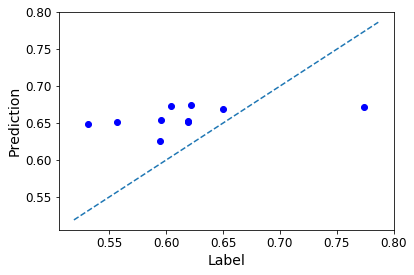

'TRAIN'


,Paclitaxel,1,2,3,4,5,6,7,8,9,...,20.1,21.1,22.1,23,24,25,26,27,28,29
10,0.705641,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.529085,0.000000,0.000000
50,0.586244,0,0.000000,1.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.988884,0.027490,0.000000,0.520218,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
73,0.641439,0,0.663784,0.000000,1,1,0.000000,0.000000,0.000000,0.137935,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.647080,0.000000,0.000000,0.000000,0.000000
75,0.589626,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.870398,0.493904,0.000000,0.471838,0.000000,0.193245,0.552905,0.000000,0.000000,0.000000
44,0.519171,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
24,0.560880,0,0.663784,0.509478,0,0,0.000000,0.000000,0.000000,0.137935,...,0.060131,0.000000,0.000000,0.447953,0.000000,0.345972,0.000000,0.000000,0.000000,0.000000
38,0.645487,1,0.671536,0.000000,0,0,0.000000,0.000000,0.000000,0.412359,...,0.226967,0.067449,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.283470,0.000000
40,0.575363,1,0.000000,0.000000,1,0,0.000000,0.458361,0.000000,0.000000,...,0.000000,0.961309,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
22,0.756732,0,0.000000,0.682574,1,1,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007712,0.434028
32,0.697379,1,0.898766,0.000000,1,0,0.000000,0.905644,0.943491,0.056235,...,0.063434,0.078721,1.000000,0.466730,0.428190,0.000000,0.998116,0.986175,0.000000,0.000000


'TEST'


,Paclitaxel,1,2,3,4,5,6,7,8,9,...,20.1,21.1,22.1,23,24,25,26,27,28,29
57,0.518664,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.788449,...,0.211407,0.000000,0.000000,0.00000,0.0,0.0,0.552905,0.000000,0.000000,0.000000
28,0.639675,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.233980,0.039806,0.000000,0.00000,0.0,0.0,0.000000,0.303572,0.000000,0.000000
2,0.748410,0,0.663784,0.000000,0,0,0.915058,0.000000,0.000000,0.137935,...,0.000000,0.000000,0.932381,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
71,0.722832,0,0.000000,0.000000,0,0,0.915058,0.834942,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
6,0.566868,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
29,0.707878,0,0.932194,0.000000,0,0,0.000000,0.871818,0.000000,0.039067,...,0.000000,0.043257,0.000000,0.00000,0.0,0.0,0.552905,0.000000,0.000000,0.832418
84,0.558231,0,0.000000,0.000000,0,0,0.000000,0.000000,0.995228,0.869212,...,0.000000,0.446125,0.000000,0.00000,0.0,0.0,0.000000,0.000595,0.000000,0.000000
54,0.659587,0,0.942652,0.000000,0,0,0.000000,0.000000,0.000000,0.033412,...,0.000000,0.027400,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
18,0.575324,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.018987,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
62,0.616177,0,0.000000,0.977566,0,0,0.000000,0.000000,0.000000,0.896149,...,0.163698,0.043257,0.000000,0.36631,0.0,0.0,0.000000,0.001529,0.080909,0.446040


c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


RMSE: 0.0814594733062
Pearson: (-0.24694410860223742, 0.49156352251817476)
Spearman: SpearmanrResult(correlation=-0.28484848484848485, pvalue=0.42503815489214547)


c:\users\bbece\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


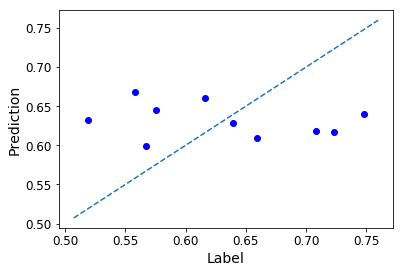

'TRAIN'


,SN-38,1,2,3,4,5,6,7,8,9,...,20.1,21.1,22.1,23,24,25,26,27,28,29
30,0.679371,0,0.663784,0.000000,0,0,0.000000,0.000000,0.000000,0.137935,...,0.036827,0.000000,0.000000,0.288723,0.000000,0.000000,0.000000,0.000000,0.004460,0.877955
72,0.602550,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.067860,0.039466,0.000000,0.000000,0.000000,0.000000,0.000000,0.009820,0.000000,0.446860
29,0.679164,0,0.932194,0.000000,0,0,0.000000,0.871818,0.000000,0.039067,...,0.000000,0.043257,0.000000,0.000000,0.000000,0.000000,0.552905,0.000000,0.000000,0.832418
19,0.602164,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.197832,0.545890,0.000000,0.000000,0.000000,0.464498,0.000000,1.000000,0.000000,0.446860
57,0.568507,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.788449,...,0.211407,0.000000,0.000000,0.000000,0.000000,0.000000,0.552905,0.000000,0.000000,0.000000
34,0.579178,0,0.920062,0.000000,1,0,0.000000,0.905644,0.940662,0.045457,...,0.063768,0.078721,0.994948,0.468501,0.428190,0.000000,0.998999,0.986175,0.000000,0.000000
38,0.632628,1,0.671536,0.000000,0,0,0.000000,0.000000,0.000000,0.412359,...,0.226967,0.067449,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.283470,0.000000
22,0.877780,0,0.000000,0.682574,1,1,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007712,0.434028
15,0.560100,0,0.943002,0.000000,0,0,0.000000,0.000000,0.000000,0.033220,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14,0.549305,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.552905,0.000000,0.000000,0.000000


'TEST'


,SN-38,1,2,3,4,5,6,7,8,9,...,20.1,21.1,22.1,23,24,25,26,27,28,29
61,0.814614,0,0.939401,0.399480,0,0,0.915058,0.000000,0.744641,0.035184,...,0.870398,0.039806,0.000000,0.530704,0.42819,0.000000,0.000000,0.000000,0.004444,0.0
26,0.655725,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.068618,0.032451,0.377962,0.000000,0.00000,0.000000,0.000000,0.000000,0.910626,0.0
21,0.621525,0,0.929884,0.961098,1,0,0.915058,0.000000,0.000000,0.040297,...,0.000000,0.356861,0.000000,0.000000,0.00000,0.490114,0.000000,0.000000,0.004665,0.0
18,0.566709,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.018987,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0
0,0.542345,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.392288,0.078721,0.000000,0.000000,0.00000,0.167822,0.000000,0.000000,0.000000,0.0
80,0.610227,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.032451,0.000000,0.000000,0.00000,0.000000,0.000000,0.185975,0.769782,0.0
32,0.606223,1,0.898766,0.000000,1,0,0.000000,0.905644,0.943491,0.056235,...,0.063434,0.078721,1.000000,0.466730,0.42819,0.000000,0.998116,0.986175,0.000000,0.0
63,0.581497,0,0.981870,1.000000,0,0,0.000000,0.000000,0.000000,0.011002,...,0.000000,0.000000,0.000000,0.612868,0.00000,0.000000,0.000000,0.068967,0.000000,0.0
42,0.682710,1,0.663784,0.997398,0,0,0.000000,0.871818,0.000000,0.137935,...,0.083147,0.000000,0.377962,0.619782,0.00000,0.728292,0.000000,0.000000,0.000000,0.0
56,0.647026,0,0.000000,0.000000,0,0,0.000000,0.871818,0.000000,0.000000,...,0.870398,0.039806,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0


c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


RMSE: 0.0804503202983
Pearson: (0.035322092766844906, 0.92282925221628787)
Spearman: SpearmanrResult(correlation=0.2121212121212121, pvalue=0.55630577510292989)


c:\users\bbece\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


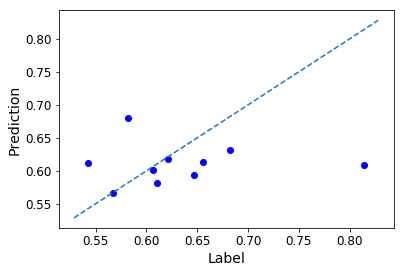

'TRAIN'


,5-FU,1,2,3,4,5,6,7,8,9,...,20.1,21.1,22.1,23,24,25,26,27,28,29
5,0.723314,0,0.000000,0.000000,1,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
61,0.875244,0,0.939401,0.399480,0,0,0.915058,0.000000,0.744641,0.035184,...,0.870398,0.039806,0.000000,0.530704,0.428190,0.000000,0.000000,0.000000,0.004444,0.000000
22,0.963176,0,0.000000,0.682574,1,1,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007712,0.434028
3,0.826889,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.028650,0.000000,0.000000,0.000000,0.000000,0.000000,0.107368,0.000000,0.000000
71,0.778938,0,0.000000,0.000000,0,0,0.915058,0.834942,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
84,0.847659,0,0.000000,0.000000,0,0,0.000000,0.000000,0.995228,0.869212,...,0.000000,0.446125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000595,0.000000,0.000000
26,0.764149,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.068618,0.032451,0.377962,0.000000,0.000000,0.000000,0.000000,0.000000,0.910626,0.000000
62,0.794304,0,0.000000,0.977566,0,0,0.000000,0.000000,0.000000,0.896149,...,0.163698,0.043257,0.000000,0.366310,0.000000,0.000000,0.000000,0.001529,0.080909,0.446040
72,0.621484,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.067860,0.039466,0.000000,0.000000,0.000000,0.000000,0.000000,0.009820,0.000000,0.446860
18,0.727964,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.018987,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


'TEST'


,5-FU,1,2,3,4,5,6,7,8,9,...,20.1,21.1,22.1,23,24,25,26,27,28,29
38,0.840813,1,0.671536,0.0,0,0,0.0,0.000000,0.000000,0.412359,...,0.226967,0.067449,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.28347,0.000000
34,0.583491,0,0.920062,0.0,1,0,0.0,0.905644,0.940662,0.045457,...,0.063768,0.078721,0.994948,0.468501,0.42819,0.000000,0.998999,0.986175,0.00000,0.000000
55,0.817725,0,0.000000,0.0,0,0,0.0,0.871818,0.000000,0.000000,...,0.000000,0.018987,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
19,0.742902,0,0.000000,0.0,0,0,0.0,0.000000,0.000000,0.000000,...,0.197832,0.545890,0.000000,0.000000,0.00000,0.464498,0.000000,1.000000,0.00000,0.446860
73,0.836726,0,0.663784,0.0,1,1,0.0,0.000000,0.000000,0.137935,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.647080,0.000000,0.000000,0.00000,0.000000
15,0.724743,0,0.943002,0.0,0,0,0.0,0.000000,0.000000,0.033220,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
30,0.822522,0,0.663784,0.0,0,0,0.0,0.000000,0.000000,0.137935,...,0.036827,0.000000,0.000000,0.288723,0.00000,0.000000,0.000000,0.000000,0.00446,0.877955
14,0.831634,0,0.000000,0.0,0,0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.552905,0.000000,0.00000,0.000000
75,0.615629,0,0.000000,0.0,0,0,0.0,0.000000,0.000000,0.000000,...,0.870398,0.493904,0.000000,0.471838,0.00000,0.193245,0.552905,0.000000,0.00000,0.000000


c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


RMSE: 0.124940181986
Pearson: (-0.56305473944844597, 0.11444832061182046)
Spearman: SpearmanrResult(correlation=-0.3666666666666667, pvalue=0.33173980143301507)


c:\users\bbece\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


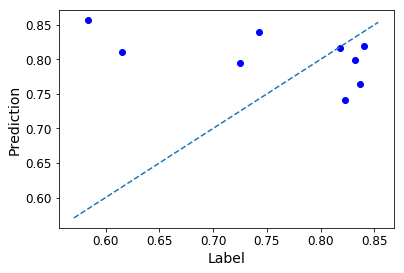

'TRAIN'


,Oxaliplatin,1,2,3,4,5,6,7,8,9,...,20.1,21.1,22.1,23,24,25,26,27,28,29
63,0.703624,0,0.981870,1.000000,0,0,0.000000,0.000000,0.000000,0.011002,...,0.000000,0.000000,0.000000,0.612868,0.000000,0.000000,0.000000,0.068967,0.000000,0.000000
75,0.777879,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.870398,0.493904,0.000000,0.471838,0.000000,0.193245,0.552905,0.000000,0.000000,0.000000
56,0.907493,0,0.000000,0.000000,0,0,0.000000,0.871818,0.000000,0.000000,...,0.870398,0.039806,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
39,0.884302,1,0.000000,0.995087,1,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.064604,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
62,0.914314,0,0.000000,0.977566,0,0,0.000000,0.000000,0.000000,0.896149,...,0.163698,0.043257,0.000000,0.366310,0.000000,0.000000,0.000000,0.001529,0.080909,0.446040
5,0.943585,0,0.000000,0.000000,1,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
36,0.755721,1,0.000000,1.000000,1,0,1.000000,0.000000,0.000000,0.987730,...,0.667935,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009820,0.000000,0.000000
18,0.850711,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.018987,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.802963,0,0.000000,0.000000,1,0,0.000000,0.000000,0.000000,0.000000,...,0.059951,0.038275,0.377962,0.446879,0.710431,0.000000,0.000000,0.000000,0.003203,0.000000
76,0.762173,0,0.000000,0.000000,0,0,0.000000,0.000000,0.940662,0.000000,...,0.000000,0.897651,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


'TEST'


,Oxaliplatin,1,2,3,4,5,6,7,8,9,...,20.1,21.1,22.1,23,24,25,26,27,28,29
17,0.800729,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.053096,0.078721,0.000000,0.403419,0.0,0.000000,0.0,0.0,0.000000,0.000000
6,0.841761,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
40,0.862368,1,0.000000,0.000000,1,0,0.000000,0.458361,0.000000,0.000000,...,0.000000,0.961309,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
60,0.794773,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.052805,0.038126,0.000000,0.401489,0.0,0.000000,0.0,0.0,0.000000,0.999993
59,0.791185,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
23,0.654267,0,0.000000,0.982915,1,0,0.000000,0.000000,0.940662,0.000000,...,0.000000,0.347998,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
21,0.795722,0,0.929884,0.961098,1,0,0.915058,0.000000,0.000000,0.040297,...,0.000000,0.356861,0.000000,0.000000,0.0,0.490114,0.0,0.0,0.004665,0.000000
44,0.783065,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
26,0.886223,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.068618,0.032451,0.377962,0.000000,0.0,0.000000,0.0,0.0,0.910626,0.000000


c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


RMSE: 0.0978032063597
Pearson: (0.23559455518584982, 0.54169948707895021)
Spearman: SpearmanrResult(correlation=-0.033333333333333333, pvalue=0.93215673554050393)


c:\users\bbece\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


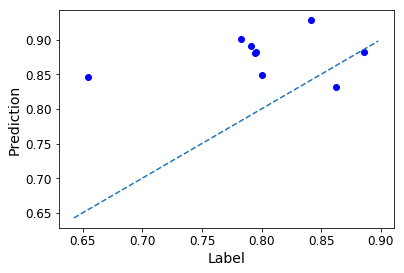

In [71]:
for label in labels:
    X_nonNA, y_nonNA = remove_NAs(X, y, label)
    X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X_nonNA, y_nonNA, test_size=0.15)
    
    display_set(X_TRAIN, X_TEST, Y_TRAIN, Y_TEST)
        
    Ypipeline, XYpipeline = retrieve_pipelines("rfs_model", RandomForestRegressor(n_estimators=500, max_leaf_nodes=32, n_jobs=8))
    
    y_test_np, y_prediction, this_y_train_tr = train_and_test(Ypipeline, XYpipeline, X_TRAIN, X_TEST, Y_TRAIN.values, Y_TEST.values)

    rmse, r, t = simple_score(y_test_np, y_prediction)
    
    print("RMSE: " + str(rmse))
    print("Pearson: " + str(r))
    print("Spearman: " + str(t))

    #scores = cv_score(XYpipeline, X_TRAIN, this_y_train_tr)
    
    #print("CV Scores: " + str(scores))
    #print("CV Mean: " + str(scores.mean()))
    #print("CV STD: " + str(scores.std()))
             
    visualize(y_test_np, y_prediction)


### Bootstrap Regression Model

RMSE: 0.112571819526
Pearson: (-0.23292974427437668, 0.06618634840317042)
Spearman: SpearmanrResult(correlation=-0.21219688908781523, pvalue=0.094997276535593325)


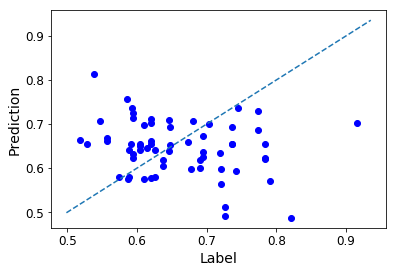

RMSE: 0.0827766242438
Pearson: (0.29963101592934971, 0.017045809747826809)
Spearman: SpearmanrResult(correlation=0.25561601572829035, pvalue=0.043177632671959433)


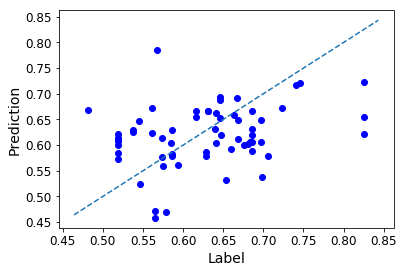

RMSE: 0.127190712611
Pearson: (-0.29156955585478034, 0.020419760202555266)
Spearman: SpearmanrResult(correlation=-0.14028643850435255, pvalue=0.27280523011351304)


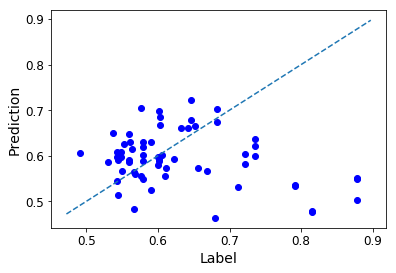

RMSE: 0.135151149357
Pearson: (-0.32296694729420644, 0.017218894234391525)
Spearman: SpearmanrResult(correlation=-0.36453946903756246, pvalue=0.0067268584919484347)


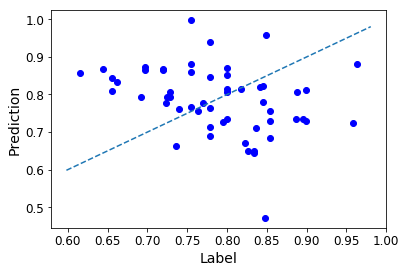

RMSE: 0.0983437327591
Pearson: (0.061246693307449772, 0.65997204066834025)
Spearman: SpearmanrResult(correlation=0.0035081701223787366, pvalue=0.97991415932558512)


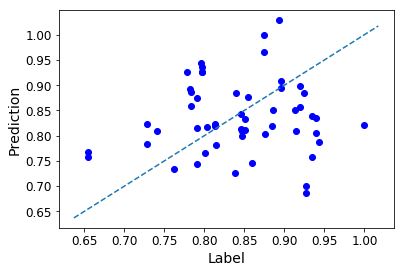

In [73]:
for label in labels:
    X_nonNA, y_nonNA = remove_NAs(X, y, label)
    
    all_y_test_np = np.array([])
    all_y_prediction = np.array([])
    for i in range(1,10):
        X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X_nonNA, y_nonNA, test_size=0.10)

        Ypipeline, XYpipeline = retrieve_pipelines("ridge_model", Ridge(alpha = 0.50))

        y_test_np, y_prediction, _ = train_and_test(Ypipeline, XYpipeline, X_TRAIN, X_TEST, Y_TRAIN.values, Y_TEST.values)
        all_y_test_np = np.append(all_y_test_np, y_test_np)
        all_y_prediction = np.append(all_y_prediction, y_prediction)
        
    rmse, r, t = simple_score(all_y_test_np, all_y_prediction)
    
    print("RMSE: " + str(rmse))
    print("Pearson: " + str(r))
    print("Spearman: " + str(t))
    visualize(all_y_test_np, all_y_prediction)


### Bootstrap Random Forest Model

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RMSE: 0.0661192614118
Pearson: (0.15123368430051648, 0.37861129083178591)
Spearman: SpearmanrResult(correlation=0.12471019249374674, pvalue=0.46864208758921633)


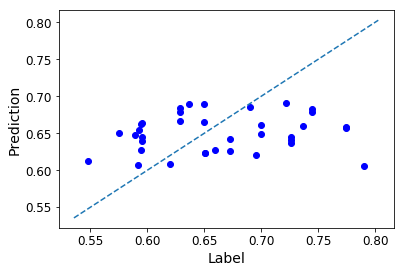

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RMSE: 0.0677158564692
Pearson: (0.15410425933830429, 0.36952100460359405)
Spearman: SpearmanrResult(correlation=0.25307844687955783, pvalue=0.13642241509817191)


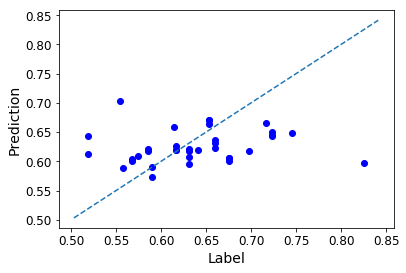

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RMSE: 0.0885138630394
Pearson: (-0.37538981257040815, 0.024066230290709811)
Spearman: SpearmanrResult(correlation=-0.32469747530748239, pvalue=0.053341735283923851)


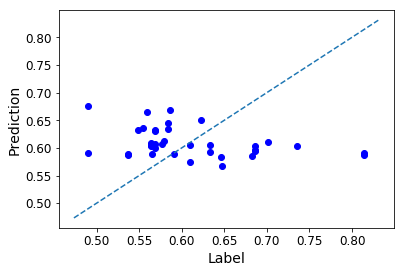

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RMSE: 0.114237384128
Pearson: (-0.14886373459682761, 0.38621436279490418)
Spearman: SpearmanrResult(correlation=-0.13262942784261389, pvalue=0.44064284159298905)


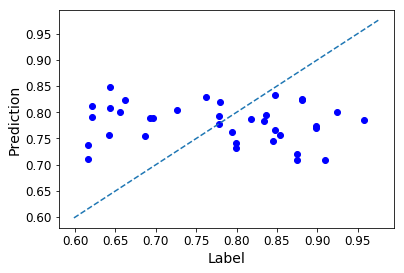

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RMSE: 0.0735247300967
Pearson: (0.11525362299155507, 0.50327049090538434)
Spearman: SpearmanrResult(correlation=0.11931460155024985, pvalue=0.48824375104050544)


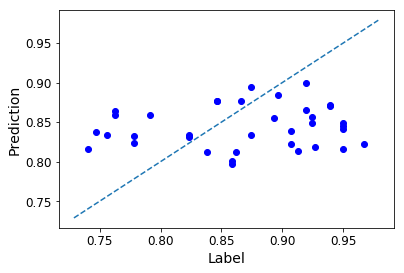

In [249]:
for label in labels:
    X_nonNA, y_nonNA = remove_NAs(X, y, label)
    
    all_y_test_np = np.array([])
    all_y_prediction = np.array([])
    for i in range(1,10):
        X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X_nonNA, y_nonNA, test_size=0.10)

        Ypipeline, XYpipeline = retrieve_pipelines("rfs_model", RandomForestRegressor(n_estimators=1000, max_leaf_nodes=8, n_jobs=4))

        y_test_np, y_prediction, _ = train_and_test(Ypipeline, XYpipeline, X_TRAIN, X_TEST, Y_TRAIN.values, Y_TEST.values)
        all_y_test_np = np.append(all_y_test_np, y_test_np)
        all_y_prediction = np.append(all_y_prediction, y_prediction)
        
    rmse, r, t = simple_score(all_y_test_np, all_y_prediction)
    
    print("RMSE: " + str(rmse))
    print("Pearson: " + str(r))
    print("Spearman: " + str(t))
    visualize(all_y_test_np, all_y_prediction)
